This tutorial is about
- Apply non-zero momentum in CNN
- Symmetry projection to excited state

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import jax.numpy as jnp
import quantax as qtx

lattice = qtx.sites.Square(4)
N = lattice.nsites

In [11]:
from quantax.symmetry import TotalSz, SpinInverse, C4v, Trans2D

# J1=1, J2=0.5, with Marshall sign rule
H = qtx.operator.Heisenberg(J=[1, 0.5], n_neighbor=[1, 2], msr=True)

trans_symm = Trans2D(sector=(2, 2))

# apply non-zero momentum by the summation in the last layer
# for details see https://journals.aps.org/prb/abstract/10.1103/PhysRevB.108.054410
net = qtx.nn.ResSum(4, 8, 4, use_sinh=True, trans_symm=trans_symm)

state = qtx.state.Variational(
    net,
    symm=TotalSz(),
    max_parallel=N*3000,
)

# sampler contains spin exchanges between nearest and next nearest neighbors
sampler = qtx.sampler.NeighborExchange(state, 1000, n_neighbor=[1, 2])
tdvp = qtx.optimizer.TDVP(state, H)

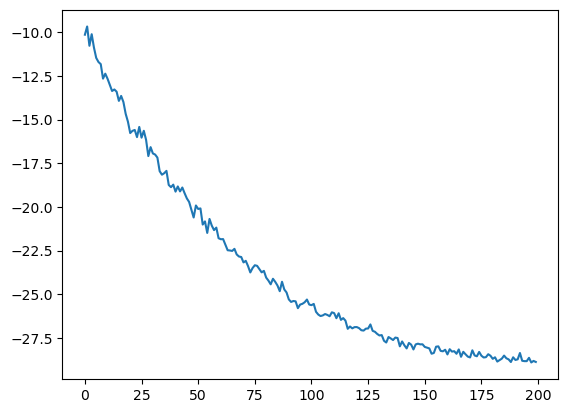

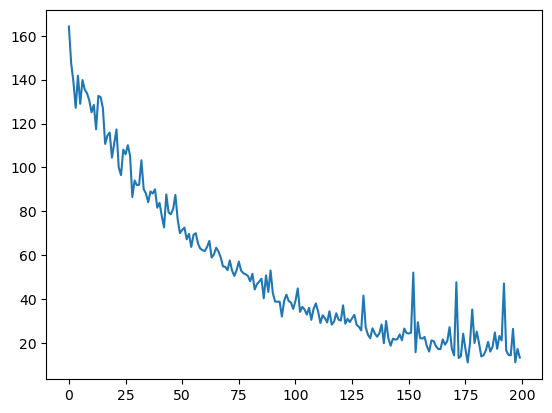

In [12]:
energy_data = qtx.utils.DataTracer()
VarE_data = qtx.utils.DataTracer()

for i in range(200):
    samples = sampler.sweep()
    step = tdvp.get_step(samples)
    state.update(step * 1e-3)
    energy_data.append(tdvp.energy)
    VarE_data.append(tdvp.VarE)

energy_data.plot()
plt.show()
VarE_data.plot()
plt.show()

In [13]:
# symmetrize the trained NQS

# SpinInverse(-1) projects to the sector psi(-s) = -psi(s)
symm = TotalSz() + SpinInverse(-1) + C4v()
symm_state = symm(state)

sampler = qtx.sampler.NeighborExchange(symm_state, 1000, n_neighbor=[1, 2])
tdvp = qtx.optimizer.TDVP(symm_state, H)

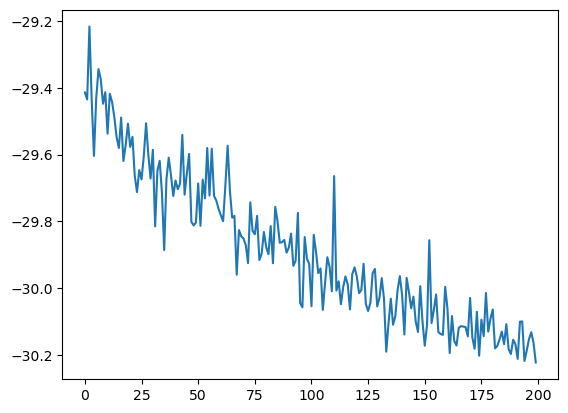

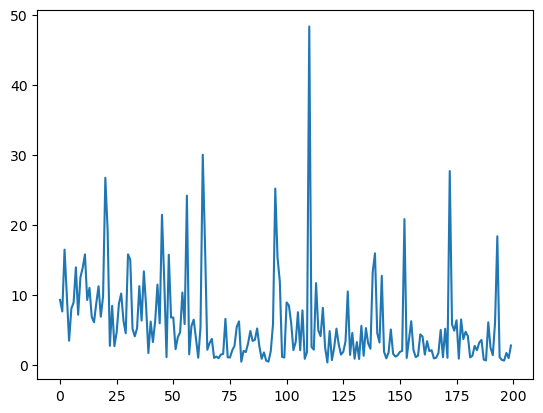

In [14]:
energy_data = qtx.utils.DataTracer()
VarE_data = qtx.utils.DataTracer()

for i in range(200):
    samples = sampler.sweep()
    step = tdvp.get_step(samples)
    symm_state.update(step * 1e-3)
    energy_data.append(tdvp.energy)
    VarE_data.append(tdvp.VarE)

energy_data.plot()
plt.show()
VarE_data.plot()
plt.show()

In [15]:
# check result by ED, also projected to excited state sector
E, wf = H.diagonalize(symm)
print(E[0])

/home/locao/miniconda3/envs/main/lib/python3.9/site-packages/quantax/symmetry/symmetry.py:126: GeneralBasisWarning: using non-commuting symmetries can lead to unwanted behaviour of general basis, make sure that quantum numbers are invariant under non-commuting symmetries!
  basis = spin_basis_general(


Hermiticity check passed!
Symmetry checks passed!
Particle conservation check passed!
-30.371072853485394
